In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
sm.set_framework('tf.keras')

In [6]:
filepath1 = "dataset/semantic_drone_dataset/original_images/"
image_paths1 = [os.path.join(filepath1, file) for file in sorted(os.listdir(filepath1))]
image_dataset = []
for path in image_paths1:
    image = cv2.imread(path, 1)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = Image.fromarray(image)
    image = np.array(image)
    image_dataset.append(image)

In [8]:
filepath2 = "RGB_color_image_masks/RGB_color_image_masks/"
image_paths2 = [os.path.join(filepath2, file) for file in sorted(os.listdir(filepath2))]
mask_dataset = []
for path in image_paths2:
    image = cv2.imread(path, 1)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = Image.fromarray(image)
    image = np.array(image)
    mask_dataset.append(image)

In [9]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
mask_dataset.shape

(400, 128, 128, 3)

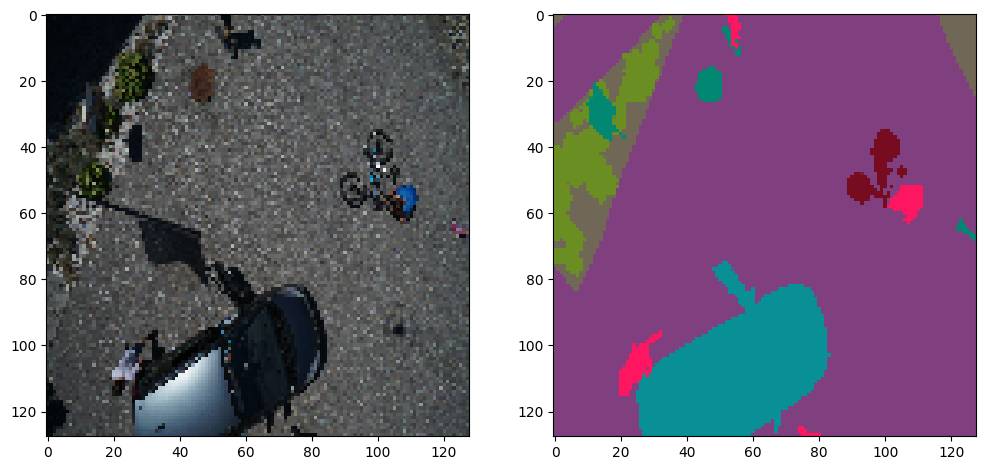

In [13]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [14]:
mask_labels = pd.read_csv("class_dict_seg.csv")

In [15]:
mask_labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [16]:
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels...
    return label_seg

In [17]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images...
    labels.append(label)

In [18]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [19]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


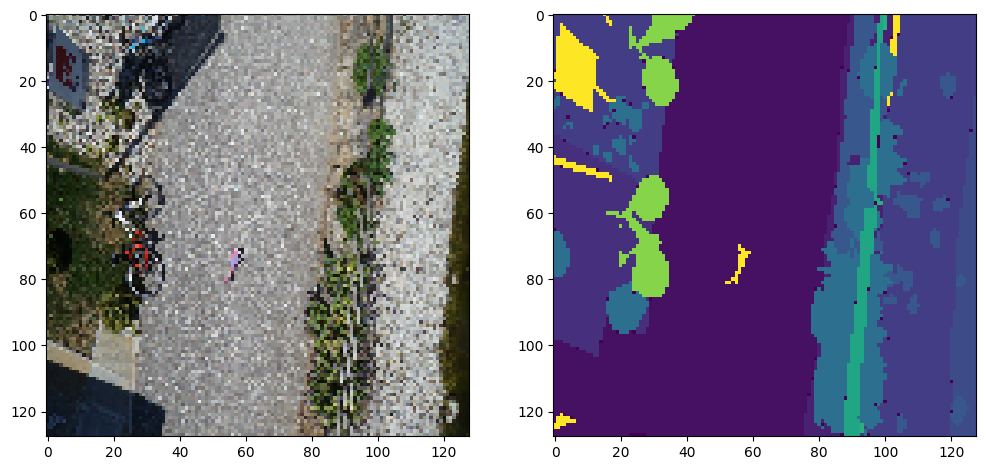

In [26]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [27]:
n_classes = len(np.unique(labels)) # 23 classes...
labels_cat = to_categorical(labels, num_classes=n_classes)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [29]:
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model_resnet_backbone.summary()

2023-10-22 10:52:43.972054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 10:52:43.972354: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

In [30]:
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test),shuffle=True)

Epoch 1/100
20/20 [==============================] - 12s 391ms/step - loss: 2.4199 - accuracy: 0.3585 - val_loss: 248.3734 - val_accuracy: 0.3778
Epoch 2/100
20/20 [==============================] - 7s 346ms/step - loss: 1.6682 - accuracy: 0.5560 - val_loss: 7958.1201 - val_accuracy: 0.3788
Epoch 3/100
20/20 [==============================] - 7s 355ms/step - loss: 1.4672 - accuracy: 0.6038 - val_loss: 19.5203 - val_accuracy: 0.3902
Epoch 4/100
20/20 [==============================] - 7s 353ms/step - loss: 1.3283 - accuracy: 0.6400 - val_loss: 47.0315 - val_accuracy: 0.5154
Epoch 5/100
20/20 [==============================] - 7s 346ms/step - loss: 1.2521 - accuracy: 0.6526 - val_loss: 143.7742 - val_accuracy: 0.5287
Epoch 6/100
20/20 [==============================] - 7s 370ms/step - loss: 1.1849 - accuracy: 0.6624 - val_loss: 2.7336 - val_accuracy: 0.5847
Epoch 7/100
20/20 [==============================] - 7s 354ms/step - loss: 1.0777 - accuracy: 0.6933 - val_loss: 1.4564 - val_accura

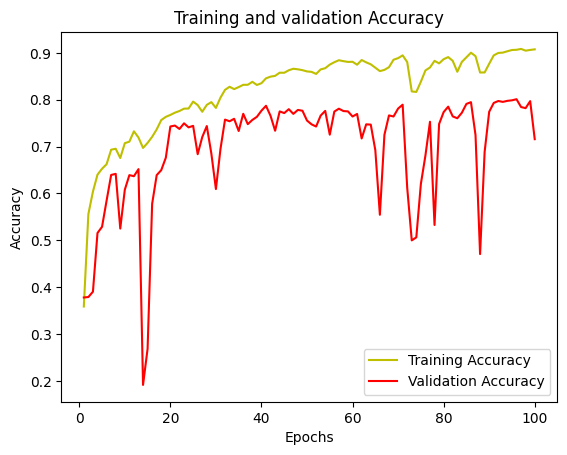

In [31]:
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
model_resnet_backbone.save('../models/resnet_backbone.hdf5')
model = load_model('../models/resnet_backbone.hdf5')

/home/dawn-m/Desktop/Projects/Semantic_Drone_Basic/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


3/3 [==============================] - 1s 185ms/step


In [38]:
test_img_number = 1
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 32ms/step


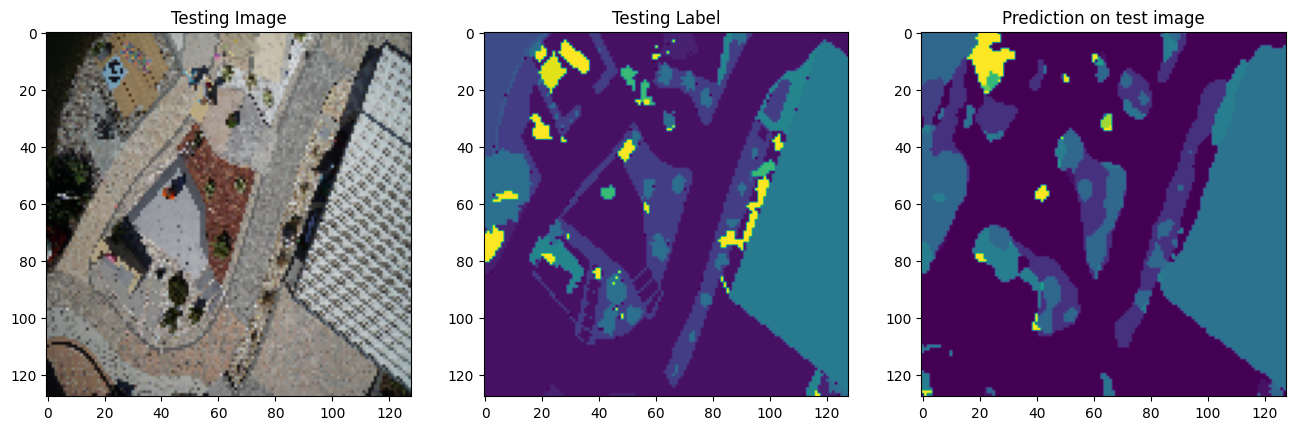

In [39]:
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()